### data1a - whole cars vs. all damaged cars

In [1]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')

In [2]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

/home/milhouse/tools/virtualenvs/car-damage-detective/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [3]:
!pwd

/home/milhouse/projects/mapfre/car-damage-detective


In [4]:
# Download vgg16_weights from https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view
def load_vgg16(weights_path='../vgg16_weights.h5'):
    
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3, img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    
    
    print(weights_path)
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path")'
    
    if weights_path:
    # note: this chops off the last layers of VGG16 

    # loads the weights of the VGG16 networks
    # note: when there is a complete match between model definition
    # and your weights savefile, you can simply call model.load_weights(filename)
        
        model.load_weights(weights_path)
       
        print('VGG16 Model with partial weights loaded.')
    else:
        print('VGG16 Model with no weights Loaded.')

    return model
#load_vgg16()

In [5]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = load_vgg16()
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16, 
                                            class_mode=None, 
                                            shuffle=False) 
    print "Generator done"
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
    print "Prediction done"
    np.save(open(location+'/bottleneck_features_train.npy', 'w'), bottleneck_features_train)
    print "Bottleneck saved"
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    print "Generator val done"
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
    print "Prediction val done"
    np.save(open(location+'/bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)
    print "Bottleneck val saved done"

#location = 'data1a'
#save_bottleneck_features(location)

In [6]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print "Best Model:" 
    print_best_model_results(hist)

In [7]:
def train_binary_model():

    train_data = np.load(open(location+'/bottleneck_features_train.npy'))
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(open(location+'/bottleneck_features_validation.npy'))
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
    model.add(Dense(256, activation = 'relu', W_regularizer=l2(0.01)))
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation = 'sigmoid')) # should activation be sigmoid for binary problem?

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    fit = model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [8]:
def finetune_binary_model():
    model = load_vgg16()

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', W_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    # add the model on top of the convolutional base
    model.add(top_model)
    
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:25]:
        layer.trainable=False

    # compile the model with a SGD/momentum optimizer 
    # and a very slow learning rate
    model.compile(loss='binary_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='binary')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
    # fine-tune the model
    fit = model.fit_generator(train_generator,
                              samples_per_epoch=nb_train_samples,
                              nb_epoch=nb_epoch,
                              validation_data=validation_generator,
                              nb_val_samples=nb_validation_samples,
                              verbose=1,
                              callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [9]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary', # categorical for multiclass
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    # use for multiclass
    # pred_labels = np.argmax(predictions, axis=1)
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print ''
    print classification_report(validation_labels, pred_labels)
    print ''
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='g');

In [10]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = raw_input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [11]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print 'epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_acc'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch]

## Testing Image Generation

In [12]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest') # omitted rescaling to keep the images displayable

#img = load_img('/home/milhouse/datasets/cars/car-damage-dataset/data1a/training/00-damage/0039.JPEG') # this is a PIL image 
img = load_img('data1a/training/00-damage/0039.JPEG') # this is a PIL image 
x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
print x.shape
#x = x.reshape(1,x.shape[2], x.shape[0], x.shape[1])
#print x.shape
x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the 'preview/' directory
os.makedirs('data1a_preview')
i = 0
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='data1a_preview', save_prefix='damage_car',
                         save_format='jpeg'):
    i +=1
    if i > 30:
        break # otherwise the generator would loop indefinitely

(3, 189, 266)


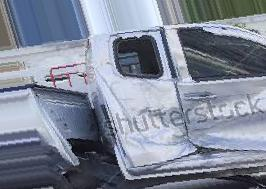

c to continue, q to quitq


'Finished for now.'

In [13]:
view_images('data1a_preview/', os.listdir('data1a_preview/'))

## Defining input data

In [14]:
# path to the model weights file
location = 'data1a'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
# model_path = location + '/initial_data2_model.h5'
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50

In [15]:
#!ls -al `pwd`/..

In [16]:
# do not rerun!!
save_bottleneck_features(location)

../vgg16_weights.h5
VGG16 Model with partial weights loaded.
Found 1840 images belonging to 2 classes.
Generator done
Prediction done
Bottleneck saved
Found 460 images belonging to 2 classes.
Generator val done
Prediction val done
Bottleneck val saved done


In [17]:
d1a_model1, d1a_history1 = train_binary_model()

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 32s - loss: 5.6541 - acc: 0.6880 - val_loss: 5.4971 - val_acc: 0.8152
Epoch 2/50
1840/1840 [==============================] - 34s - loss: 5.4638 - acc: 0.8179 - val_loss: 5.3751 - val_acc: 0.8739
Epoch 3/50
1840/1840 [==============================] - 33s - loss: 5.3938 - acc: 0.8321 - val_loss: 5.3307 - val_acc: 0.8783
Epoch 4/50
1840/1840 [==============================] - 38s - loss: 5.3369 - acc: 0.8658 - val_loss: 5.2986 - val_acc: 0.8761
Epoch 5/50
1840/1840 [==============================] - 38s - loss: 5.2945 - acc: 0.8674 - val_loss: 5.2418 - val_acc: 0.8804
Epoch 6/50
1840/1840 [==============================] - 37s - loss: 5.2634 - acc: 0.8641 - val_loss: 5.2179 - val_acc: 0.8826
Epoch 7/50
1840/1840 [==============================] - 32s - loss: 5.2254 - acc: 0.8837 - val_loss: 5.1869 - val_acc: 0.8957
Epoch 8/50
1840/1840 [==============================] - 33s - loss: 5.1

1840/1840 [==============================] - 32s - loss: 4.5513 - acc: 0.9543 - val_loss: 4.6472 - val_acc: 0.9022
Epoch 32/50
1840/1840 [==============================] - 31s - loss: 4.5334 - acc: 0.9576 - val_loss: 4.6003 - val_acc: 0.9196
Epoch 33/50
1840/1840 [==============================] - 32s - loss: 4.5155 - acc: 0.9538 - val_loss: 4.5799 - val_acc: 0.9174
Epoch 34/50
1840/1840 [==============================] - 32s - loss: 4.4903 - acc: 0.9571 - val_loss: 4.5662 - val_acc: 0.9109
Epoch 35/50
1840/1840 [==============================] - 35s - loss: 4.4602 - acc: 0.9625 - val_loss: 4.5421 - val_acc: 0.9109
Epoch 36/50
1840/1840 [==============================] - 32s - loss: 4.4497 - acc: 0.9549 - val_loss: 4.5246 - val_acc: 0.9109
Epoch 37/50
1840/1840 [==============================] - 33s - loss: 4.4129 - acc: 0.9674 - val_loss: 4.5005 - val_acc: 0.9152
Epoch 38/50
1840/1840 [==============================] - 33s - loss: 4.4054 - acc: 0.9603 - val_loss: 4.4842 - val_acc: 0.9

In [18]:
d1a_model2, d1a_history2 = train_binary_model()

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 32s - loss: 5.6410 - acc: 0.7103 - val_loss: 5.4734 - val_acc: 0.8413
Epoch 2/50
1840/1840 [==============================] - 32s - loss: 5.4578 - acc: 0.8299 - val_loss: 5.3847 - val_acc: 0.8630
Epoch 3/50
1840/1840 [==============================] - 32s - loss: 5.3767 - acc: 0.8484 - val_loss: 5.3235 - val_acc: 0.8783
Epoch 4/50
1840/1840 [==============================] - 32s - loss: 5.3532 - acc: 0.8543 - val_loss: 5.2960 - val_acc: 0.8761
Epoch 5/50
1840/1840 [==============================] - 34s - loss: 5.3008 - acc: 0.8723 - val_loss: 5.2633 - val_acc: 0.8804
Epoch 6/50
1840/1840 [==============================] - 33s - loss: 5.2675 - acc: 0.8685 - val_loss: 5.2159 - val_acc: 0.8804
Epoch 7/50
1840/1840 [==============================] - 33s - loss: 5.2297 - acc: 0.8837 - val_loss: 5.1911 - val_acc: 0.8870
Epoch 8/50
1840/1840 [==============================] - 33s - loss: 5.1

1840/1840 [==============================] - 32s - loss: 4.5632 - acc: 0.9533 - val_loss: 4.6273 - val_acc: 0.9109
Epoch 32/50
1840/1840 [==============================] - 31s - loss: 4.5324 - acc: 0.9565 - val_loss: 4.6029 - val_acc: 0.9152
Epoch 33/50
1840/1840 [==============================] - 31s - loss: 4.5134 - acc: 0.9582 - val_loss: 4.5878 - val_acc: 0.9130
Epoch 34/50
1840/1840 [==============================] - 31s - loss: 4.4871 - acc: 0.9641 - val_loss: 4.5663 - val_acc: 0.9130
Epoch 35/50
1840/1840 [==============================] - 32s - loss: 4.4579 - acc: 0.9701 - val_loss: 4.5531 - val_acc: 0.9130
Epoch 36/50
1840/1840 [==============================] - 33s - loss: 4.4419 - acc: 0.9647 - val_loss: 4.5403 - val_acc: 0.9174
Epoch 37/50
1840/1840 [==============================] - 33s - loss: 4.4184 - acc: 0.9690 - val_loss: 4.5053 - val_acc: 0.9130
Epoch 38/50
1840/1840 [==============================] - 32s - loss: 4.3943 - acc: 0.9674 - val_loss: 4.4846 - val_acc: 0.9

In [19]:
d1a_model3, d1a_history3 = train_binary_model() 

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 34s - loss: 5.6365 - acc: 0.7038 - val_loss: 5.4351 - val_acc: 0.8783
Epoch 2/50
1840/1840 [==============================] - 33s - loss: 5.4746 - acc: 0.8147 - val_loss: 5.3661 - val_acc: 0.8739
Epoch 3/50
1840/1840 [==============================] - 35s - loss: 5.3967 - acc: 0.8332 - val_loss: 5.3070 - val_acc: 0.8913
Epoch 4/50
1840/1840 [==============================] - 33s - loss: 5.3514 - acc: 0.8511 - val_loss: 5.2712 - val_acc: 0.8870
Epoch 5/50
1840/1840 [==============================] - 33s - loss: 5.2972 - acc: 0.8761 - val_loss: 5.2316 - val_acc: 0.8913
Epoch 6/50
1840/1840 [==============================] - 33s - loss: 5.2370 - acc: 0.8815 - val_loss: 5.2031 - val_acc: 0.8913
Epoch 7/50
1840/1840 [==============================] - 34s - loss: 5.2199 - acc: 0.8826 - val_loss: 5.2021 - val_acc: 0.8935
Epoch 8/50
1840/1840 [==============================] - 32s - loss: 5.1

1840/1840 [==============================] - 34s - loss: 4.5273 - acc: 0.9630 - val_loss: 4.5946 - val_acc: 0.9152
Epoch 33/50
1840/1840 [==============================] - 33s - loss: 4.5018 - acc: 0.9609 - val_loss: 4.5750 - val_acc: 0.9239
Epoch 34/50
1840/1840 [==============================] - 33s - loss: 4.4918 - acc: 0.9560 - val_loss: 4.5557 - val_acc: 0.9152
Epoch 35/50
1840/1840 [==============================] - 33s - loss: 4.4550 - acc: 0.9663 - val_loss: 4.5339 - val_acc: 0.9217
Epoch 36/50
1840/1840 [==============================] - 32s - loss: 4.4351 - acc: 0.9668 - val_loss: 4.5132 - val_acc: 0.9217
Epoch 37/50
1840/1840 [==============================] - 33s - loss: 4.4104 - acc: 0.9717 - val_loss: 4.4995 - val_acc: 0.9261
Epoch 38/50
1840/1840 [==============================] - 32s - loss: 4.3858 - acc: 0.9707 - val_loss: 4.4833 - val_acc: 0.9239
Epoch 39/50
1840/1840 [==============================] - 32s - loss: 4.3706 - acc: 0.9674 - val_loss: 4.4581 - val_acc: 0.9

In [20]:
d1a_model4, d1a_history4 = train_binary_model() 

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 32s - loss: 5.6312 - acc: 0.7120 - val_loss: 5.4512 - val_acc: 0.8739
Epoch 2/50
1840/1840 [==============================] - 33s - loss: 5.4488 - acc: 0.8293 - val_loss: 5.4317 - val_acc: 0.8304
Epoch 3/50
1840/1840 [==============================] - 32s - loss: 5.3885 - acc: 0.8478 - val_loss: 5.3078 - val_acc: 0.8870
Epoch 4/50
1840/1840 [==============================] - 32s - loss: 5.3428 - acc: 0.8543 - val_loss: 5.3172 - val_acc: 0.8761
Epoch 5/50
1840/1840 [==============================] - 32s - loss: 5.2874 - acc: 0.8804 - val_loss: 5.2449 - val_acc: 0.8913
Epoch 6/50
1840/1840 [==============================] - 34s - loss: 5.2476 - acc: 0.8870 - val_loss: 5.2334 - val_acc: 0.8826
Epoch 7/50
1840/1840 [==============================] - 33s - loss: 5.2294 - acc: 0.8734 - val_loss: 5.1929 - val_acc: 0.8978
Epoch 8/50
1840/1840 [==============================] - 34s - loss: 5.1

1840/1840 [==============================] - 33s - loss: 4.5580 - acc: 0.9565 - val_loss: 4.6319 - val_acc: 0.9087
Epoch 32/50
1840/1840 [==============================] - 33s - loss: 4.5328 - acc: 0.9571 - val_loss: 4.6195 - val_acc: 0.9065
Epoch 33/50
1840/1840 [==============================] - 32s - loss: 4.5151 - acc: 0.9582 - val_loss: 4.5784 - val_acc: 0.9217
Epoch 34/50
1840/1840 [==============================] - 32s - loss: 4.4918 - acc: 0.9549 - val_loss: 4.5616 - val_acc: 0.9196
Epoch 35/50
1840/1840 [==============================] - 32s - loss: 4.4575 - acc: 0.9674 - val_loss: 4.5459 - val_acc: 0.9109
Epoch 36/50
1840/1840 [==============================] - 32s - loss: 4.4389 - acc: 0.9690 - val_loss: 4.5268 - val_acc: 0.9196
Epoch 37/50
1840/1840 [==============================] - 33s - loss: 4.4169 - acc: 0.9630 - val_loss: 4.5032 - val_acc: 0.9217
Epoch 38/50
1840/1840 [==============================] - 35s - loss: 4.3980 - acc: 0.9679 - val_loss: 4.4804 - val_acc: 0.9

In [21]:
d1a_model5, d1a_history5 = train_binary_model() 

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 33s - loss: 5.6188 - acc: 0.7098 - val_loss: 5.4381 - val_acc: 0.8609
Epoch 2/50
1840/1840 [==============================] - 32s - loss: 5.4580 - acc: 0.8152 - val_loss: 5.3562 - val_acc: 0.8783
Epoch 3/50
1840/1840 [==============================] - 33s - loss: 5.4039 - acc: 0.8402 - val_loss: 5.3345 - val_acc: 0.8804
Epoch 4/50
1840/1840 [==============================] - 32s - loss: 5.3305 - acc: 0.8668 - val_loss: 5.2662 - val_acc: 0.8913
Epoch 5/50
1840/1840 [==============================] - 32s - loss: 5.2980 - acc: 0.8641 - val_loss: 5.2521 - val_acc: 0.8891
Epoch 6/50
1840/1840 [==============================] - 33s - loss: 5.2477 - acc: 0.8837 - val_loss: 5.2161 - val_acc: 0.8913
Epoch 7/50
1840/1840 [==============================] - 35s - loss: 5.2240 - acc: 0.8837 - val_loss: 5.1772 - val_acc: 0.8978
Epoch 8/50
1840/1840 [==============================] - 33s - loss: 5.1

1840/1840 [==============================] - 37s - loss: 4.5799 - acc: 0.9495 - val_loss: 4.6400 - val_acc: 0.9217
Epoch 31/50
1840/1840 [==============================] - 37s - loss: 4.5529 - acc: 0.9576 - val_loss: 4.6383 - val_acc: 0.9109
Epoch 32/50
1840/1840 [==============================] - 37s - loss: 4.5390 - acc: 0.9533 - val_loss: 4.6000 - val_acc: 0.9217
Epoch 33/50
1840/1840 [==============================] - 38s - loss: 4.5055 - acc: 0.9625 - val_loss: 4.5860 - val_acc: 0.9109
Epoch 34/50
1840/1840 [==============================] - 37s - loss: 4.4823 - acc: 0.9636 - val_loss: 4.5646 - val_acc: 0.9130
Epoch 35/50
1840/1840 [==============================] - 39s - loss: 4.4496 - acc: 0.9685 - val_loss: 4.5411 - val_acc: 0.9152
Epoch 36/50
1840/1840 [==============================] - 37s - loss: 4.4440 - acc: 0.9587 - val_loss: 4.5197 - val_acc: 0.9217
Epoch 37/50
1840/1840 [==============================] - 38s - loss: 4.4189 - acc: 0.9582 - val_loss: 4.5001 - val_acc: 0.9

In [22]:
d1a_model6, d1a_history6 = train_binary_model() 

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 37s - loss: 5.6537 - acc: 0.6918 - val_loss: 5.4506 - val_acc: 0.8870
Epoch 2/50
1840/1840 [==============================] - 37s - loss: 5.4664 - acc: 0.8168 - val_loss: 5.3676 - val_acc: 0.9000
Epoch 3/50
1840/1840 [==============================] - 37s - loss: 5.3853 - acc: 0.8538 - val_loss: 5.3435 - val_acc: 0.8587
Epoch 4/50
1840/1840 [==============================] - 37s - loss: 5.3403 - acc: 0.8582 - val_loss: 5.2799 - val_acc: 0.9043
Epoch 5/50
1840/1840 [==============================] - 37s - loss: 5.2976 - acc: 0.8734 - val_loss: 5.2411 - val_acc: 0.9022
Epoch 6/50
1840/1840 [==============================] - 41s - loss: 5.2669 - acc: 0.8750 - val_loss: 5.2109 - val_acc: 0.9065
Epoch 7/50
1840/1840 [==============================] - 39s - loss: 5.2192 - acc: 0.8897 - val_loss: 5.1900 - val_acc: 0.9022
Epoch 8/50
1840/1840 [==============================] - 38s - loss: 5.1

1840/1840 [==============================] - 32s - loss: 4.5441 - acc: 0.9505 - val_loss: 4.6048 - val_acc: 0.9217
Epoch 33/50
1840/1840 [==============================] - 33s - loss: 4.5189 - acc: 0.9560 - val_loss: 4.5770 - val_acc: 0.9152
Epoch 34/50
1840/1840 [==============================] - 34s - loss: 4.4913 - acc: 0.9609 - val_loss: 4.5569 - val_acc: 0.9239
Epoch 35/50
1840/1840 [==============================] - 33s - loss: 4.4679 - acc: 0.9614 - val_loss: 4.5386 - val_acc: 0.9196
Epoch 36/50
1840/1840 [==============================] - 33s - loss: 4.4460 - acc: 0.9630 - val_loss: 4.5361 - val_acc: 0.9174
Epoch 37/50
1840/1840 [==============================] - 34s - loss: 4.4261 - acc: 0.9636 - val_loss: 4.5034 - val_acc: 0.9217
Epoch 38/50
1840/1840 [==============================] - 35s - loss: 4.4055 - acc: 0.9630 - val_loss: 4.4790 - val_acc: 0.9196
Epoch 39/50
1840/1840 [==============================] - 41s - loss: 4.3801 - acc: 0.9652 - val_loss: 4.4590 - val_acc: 0.9

In [23]:
d1a_model7, d1a_history7 = train_binary_model()

Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 33s - loss: 5.6326 - acc: 0.7076 - val_loss: 5.4392 - val_acc: 0.8717
Epoch 2/50
1840/1840 [==============================] - 35s - loss: 5.4645 - acc: 0.8185 - val_loss: 5.3640 - val_acc: 0.8739
Epoch 3/50
1840/1840 [==============================] - 48s - loss: 5.3887 - acc: 0.8500 - val_loss: 5.3203 - val_acc: 0.8870
Epoch 4/50
1840/1840 [==============================] - 35s - loss: 5.3212 - acc: 0.8739 - val_loss: 5.2884 - val_acc: 0.8783
Epoch 5/50
1840/1840 [==============================] - 34s - loss: 5.2939 - acc: 0.8652 - val_loss: 5.2725 - val_acc: 0.8717
Epoch 6/50
1840/1840 [==============================] - 33s - loss: 5.2582 - acc: 0.8685 - val_loss: 5.2164 - val_acc: 0.8957
Epoch 7/50
1840/1840 [==============================] - 33s - loss: 5.2247 - acc: 0.8810 - val_loss: 5.2151 - val_acc: 0.8826
Epoch 8/50
1840/1840 [==============================] - 33s - loss: 5.1

1840/1840 [==============================] - 35s - loss: 4.5485 - acc: 0.9614 - val_loss: 4.6257 - val_acc: 0.9196
Epoch 32/50
1840/1840 [==============================] - 32s - loss: 4.5316 - acc: 0.9565 - val_loss: 4.6042 - val_acc: 0.9174
Epoch 33/50
1840/1840 [==============================] - 34s - loss: 4.5042 - acc: 0.9598 - val_loss: 4.5861 - val_acc: 0.9239
Epoch 34/50
1840/1840 [==============================] - 32s - loss: 4.4881 - acc: 0.9609 - val_loss: 4.5783 - val_acc: 0.9109
Epoch 35/50
1840/1840 [==============================] - 32s - loss: 4.4659 - acc: 0.9582 - val_loss: 4.5497 - val_acc: 0.9109
Epoch 36/50
1840/1840 [==============================] - 33s - loss: 4.4424 - acc: 0.9630 - val_loss: 4.5447 - val_acc: 0.9130
Epoch 37/50
1840/1840 [==============================] - 32s - loss: 4.4215 - acc: 0.9592 - val_loss: 4.5049 - val_acc: 0.9217
Epoch 38/50
1840/1840 [==============================] - 33s - loss: 4.3898 - acc: 0.9717 - val_loss: 4.5052 - val_acc: 0.9

Best Model:
epoch: 32 , val_acc: 0.9195652173913044 , val_loss: 4.600271992061449


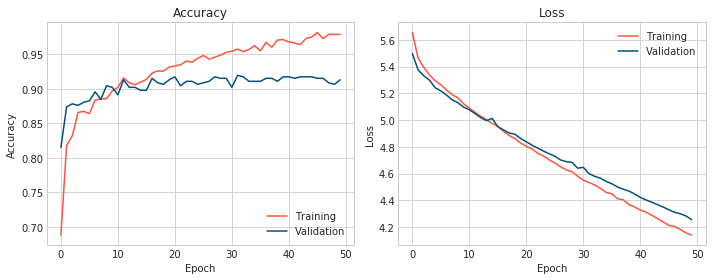

In [24]:
plot_metrics(d1a_history1) # rmsprop, sigmoid, no regularization

Best Model:
epoch: 24 , val_acc: 0.9239130439965622 , val_loss: 4.775130748748779


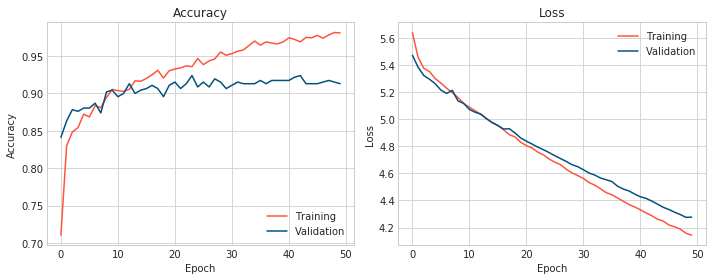

In [25]:
plot_metrics(d1a_history2) # rmsprop, sigmoid, with l2 regularization (0.01)

Best Model:
epoch: 37 , val_acc: 0.9260869570400404 , val_loss: 4.499486898339313


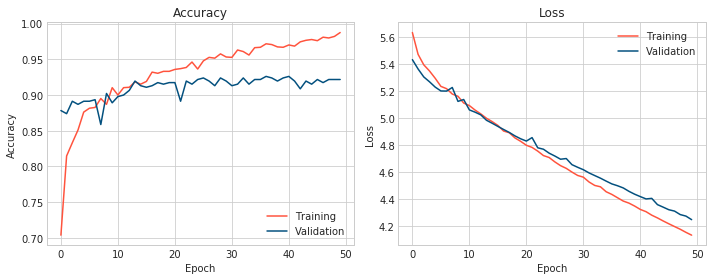

In [26]:
plot_metrics(d1a_history3) # rmsprop, sigmoid, with double dense and dropout layers

Best Model:
epoch: 27 , val_acc: 0.9282608695652174 , val_loss: 4.702636843142302


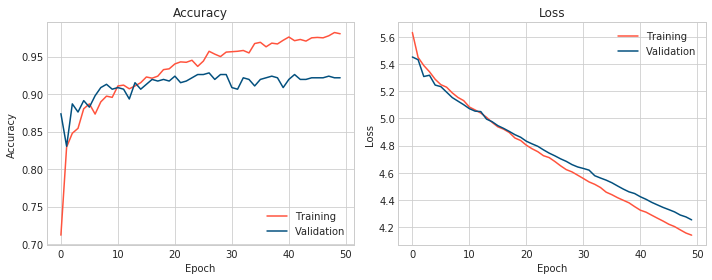

In [27]:
plot_metrics(d1a_history4) # rmsprop, sigmoid, with aggresive dropout (.75)

Best Model:
epoch: 27 , val_acc: 0.9239130434782609 , val_loss: 4.703052176599917


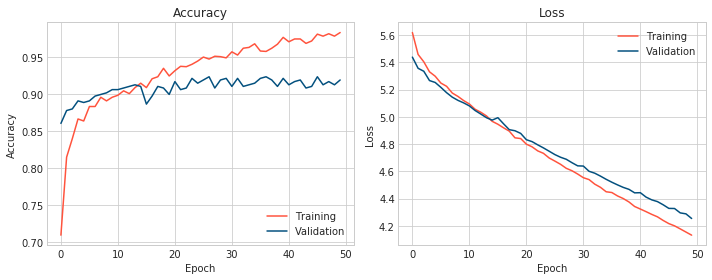

In [28]:
plot_metrics(d1a_history5) # rmsprop, sigmoid, with l2 = 0.001

Best Model:
epoch: 34 , val_acc: 0.9239130434782609 , val_loss: 4.556914789780326


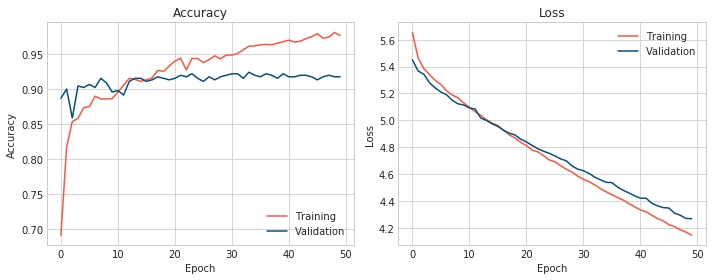

In [29]:
plot_metrics(d1a_history6) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

Best Model:
epoch: 34 , val_acc: 0.9239130434782609 , val_loss: 4.556914789780326


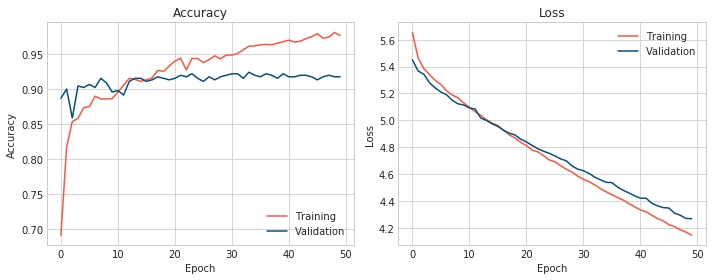

In [30]:
# WINNER
plot_metrics(d1a_history6) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

Best Model:
epoch: 30 , val_acc: 0.9239130434782609 , val_loss: 4.644585684071417


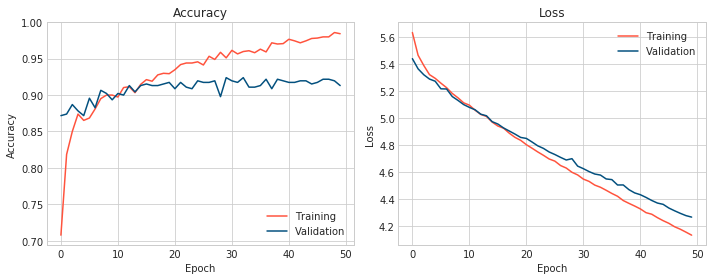

In [31]:
plot_metrics(d1a_history7) # sgd with lr = 0.001 and decay 1e-6, sigmoid, with l2 = 0.001

## Fine Tuning

In [ ]:
ft_model, ft_history = finetune_binary_model()

../vgg16_weights.h5
VGG16 Model with partial weights loaded.
Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/50
1520/1840 [=======================>......] - ETA: 6464s - loss: 4.8738 - acc: 0.7888

In [ ]:
# WINNER
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

## Load Model Point

In [ ]:
ft_model = load_model(location+'/ft_model.h5')

In [ ]:
with open('data1a/top_history.txt') as f:    
    top_history = json.load(f)

In [ ]:
with open('data1a/ft_history.txt') as f:    
    ft_history = json.load(f)

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print "Best Model:" 
    print_best_model_results(hist)

In [ ]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [ ]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary', # categorical for multiclass
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    # use for multiclass
    # pred_labels = np.argmax(predictions, axis=1)
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print ''
    print classification_report(validation_labels, pred_labels)
    print ''
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm 

In [ ]:
plot_acc_metrics(top_history, ft_history)

In [ ]:
# WINNER
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

In [ ]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1])

In [ ]:
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

In [ ]:
heatmap_labels = ['Damaged', 'Whole']

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Making Live Predictions

In [ ]:
def car_categories_gate(image_path, model):
    urllib.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    print "Validating that damage exists..."
    print pred
    if pred[0][0] <=.5:

        print "Validation complete - proceed to location and severity determination"
    else:
        print "Are you sure that your car is damaged? Please submit another picture of the damage."
        print "Hint: Try zooming in/out, using a different angle or different lighting"

In [ ]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [ ]:
car_categories_gate('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

In [ ]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [ ]:
car_categories_gate('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

In [ ]:
Image('https://www.carfax.com/media/zoo/images/rsz_frame-damage_85730e0a843d155e25e4b0f0e100bf65.jpg')

In [ ]:
car_categories_gate('https://www.carfax.com/media/zoo/images/rsz_frame-damage_85730e0a843d155e25e4b0f0e100bf65.jpg', ft_model)

## Looking at edge cases

In [ ]:
def get_edge_cases(model, directory, exp_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
        pred_prob = model.predict(x)
        if pred_prob <=0.5:
            pred = 0
        else:
            pred = 1
        if pred != exp_result:
            edge_list.append(name)
    return edge_list

In [ ]:
evaluate_binary_model(ft_model, validation_data_dir, validation_labels)
# TP = 221, TN = 194, FP = 36, FN = 9
# 9 were predicted to be damaged but were actually whole
# 36 were predicted to be whole but were actually damaged

In [ ]:
fp = get_edge_cases(ft_model, 'data1a/validation/00-damage/', 0)

In [ ]:
len(fp)

In [ ]:
view_images('data1a/validation/00-damage/', fp)  # damaged, identifed as whole

In [ ]:
fn = get_edge_cases(ft_model, 'data1a/validation/01-whole/', 1)

In [ ]:
view_images('data1a/validation/01-whole/', fn) #whole, identified as damaged